In [1]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import GenSyntheticMNSITFixedWidthModule as GenDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Extracting mnist/train-images-idx3-ubyte.gz


/home/ankdesh/installed/anaconda2/envs/tf0.11/lib/python2.7/gzip.py:275: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  chunk = self.extrabuf[offset: offset + size]
/home/ankdesh/installed/anaconda2/envs/tf0.11/lib/python2.7/site-packages/tflearn/datasets/mnist.py:52: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [4]:
# Consts
DATSET_SIZE = 10000
WIDTH_NUMS = 2

In [5]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    print (index_offset + labels_dense.ravel())
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [6]:
# Get the dataset
X, Y = GenDataset.getDataSet(WIDTH_NUMS, DATSET_SIZE)
X = X.reshape([-1, 28, 28 * WIDTH_NUMS, 1])

In [7]:
print (X.shape)

(10000, 28, 56, 1)


In [8]:
# Generate validation set
ratio = 0.8 # Train/Test set
randIdx = np.random.random(DATSET_SIZE) > ratio
#print (sum(map(lambda x: int(x), randIdx)))
X_train = X[randIdx]
Y_train = Y[randIdx]
X_test = X[randIdx == False]
Y_test = Y[randIdx == False]
Y_train = [dense_to_one_hot(Y_train[:,idx]) for idx in range(Y_train.shape[1])] 
Y_test = [dense_to_one_hot(Y_test[:,idx]) for idx in range(Y_test.shape[1])] 
del X, Y # release some space

[    8    10    27 ..., 19837 19843 19854]
[    2    19    28 ..., 19833 19847 19858]
[    2    19    25 ..., 80116 80121 80130]
[    8    16    21 ..., 80113 80126 80136]


[array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])]
(28, 56, 1)


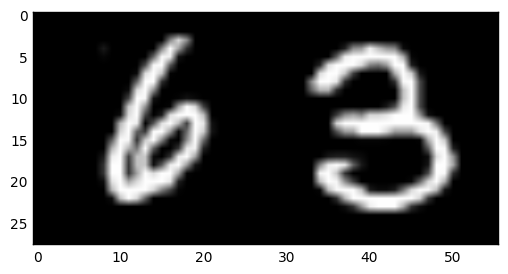

In [9]:
# Test a sample data
%matplotlib inline
idx = np.random.randint(0,X_train.shape[0])
print ([Y_train[i][idx] for i in range(len(Y_train))])
print (X_train[idx].shape)
plt.imshow(np.squeeze(X_train[idx]), cmap = 'gray')

In [10]:
# Building convolutional network
network = input_data(shape=[None, 28, 28 * WIDTH_NUMS, 1], name='input')
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
fc_1 = fully_connected(network, 128, activation='tanh')
fc_1 = dropout(fc_1, 0.8)
fc_2 = fully_connected(network, 128, activation='tanh')
fc_2 = dropout(fc_2, 0.8)
softmax1 = fully_connected(fc_1, 10, activation='softmax')
softmax2 = fully_connected(fc_2, 10, activation='softmax')
network1 = regression(softmax1, optimizer='adam', learning_rate=0.01,
                     loss='categorical_crossentropy', name='target1')
network2 = regression(softmax2, optimizer='adam', learning_rate=0.01,
                     loss='categorical_crossentropy', name='target2')
network = tflearn.merge([network1, network2], mode='elemwise_sum')

In [11]:
model = tflearn.DNN(network, tensorboard_verbose=1)
model.fit({'input': X_train}, {'target1': Y_train[0], 'target2': Y_train[1]}, 
          validation_set= (X_test, [Y_test[0], Y_test[1]]), n_epoch=5, snapshot_step=100, show_metric=True, run_id='convnet_mnist_')

Training Step: 160  | total loss: 0.21946
| Adam_0 | epoch: 005 | loss: 0.11011 - acc: 0.9747 | val_loss: 0.17437 - val_acc: 0.9456 -- iter: 1986/1986
| Adam_1 | epoch: 005 | loss: 0.10935 - acc: 0.9803 | val_loss: 0.15196 - val_acc: 0.9537 -- iter: 1986/1986
Training Step: 160  | total loss: 0.21946
| Adam_0 | epoch: 005 | loss: 0.11011 - acc: 0.9747 | val_loss: 0.17437 - val_acc: 0.9456 -- iter: 1986/1986
| Adam_1 | epoch: 005 | loss: 0.10935 - acc: 0.9803 | val_loss: 0.15196 - val_acc: 0.9537 -- iter: 1986/1986
--
